Analytic Variational Bayes. Inferring a single Gaussian
=====================

This notebook implements the example from section 3 of the FMRIB tutorial on Variational Bayes ("Inferring a single Gaussian").

We assume we have data drawn from a Gaussian distribution with true mean $\mu$ and true precision $\beta$:

$$
P(y_n | \mu, \beta) = \frac{\sqrt{\beta}}{\sqrt{2\pi}} \exp{-\frac{\beta}{2} (y_n - \mu)^2}
$$

One interpretation of this is that our data consists of repeated measurements of a fixed value ($\mu$) combined with Gaussian noise with standard deviation $\frac{1}{\sqrt{\beta}}$.

Here's how we can generate some sample data from this model in Python:

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# Ground truth parameters
# We infer the precision, BETA, but it is useful to
# derive the variance and standard deviation from it
MU_TRUTH = 42
BETA_TRUTH = 0.5
VAR_TRUTH = 1/BETA_TRUTH
STD_TRUTH = np.sqrt(VAR_TRUTH)

# Observed data samples are generated by Numpy from the ground truth
# Gaussian distribution. Reducing the number of samples should make
# the inference less 'confident' - i.e. the output variances for
# MU and BETA will increase
N = 100
DATA = np.random.normal(MU_TRUTH, STD_TRUTH, [N])
print("Data samples are:")
print(DATA)

Data samples are:
[40.98948106 37.86118187 39.66950418 41.96261222 42.22239018 41.94077753
 40.61532742 41.04771941 40.74699673 40.28652378 42.88349123 41.45707375
 42.52257784 42.84215115 39.76573134 40.42422288 42.31990607 41.10192343
 39.20101092 41.80864541 41.44475555 42.0081395  42.56279456 43.33386899
 39.12364969 41.43552665 42.02012442 42.32724268 43.41996437 41.6886275
 41.39426117 40.11340285 42.42043735 42.75072841 42.14032998 40.97892477
 42.23882452 44.02101984 45.04450886 40.86471721 41.36684423 43.73548057
 41.07032311 43.31998649 42.44706883 41.20516135 42.06716712 42.65313432
 43.8941425  40.16119185 43.43288555 43.62565808 39.84104564 41.84314308
 39.84618862 44.2392282  44.61812279 39.40577944 42.96876596 44.47728906
 41.36194737 43.8859924  43.80432801 43.61056016 43.6853317  40.84330693
 42.53932989 43.18567994 41.46011338 41.65731338 42.16185726 38.79203624
 40.25287624 43.22848603 41.59315091 41.67589152 42.87168109 40.43708093
 38.55669509 42.43586276 43.037728

In the 'signal + noise' interpretation we can view this as noisy measurements (red crosses) of a constant signal (green line):

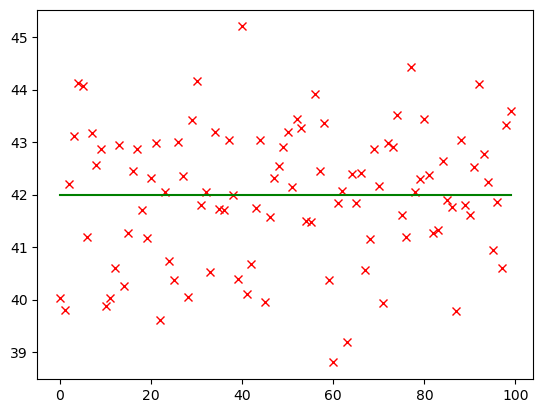

In [2]:
#from matplotlib import pyplot as plt
plt.figure()
plt.plot(DATA, "rx")
plt.plot([MU_TRUTH] * N, "g")

In Variational Bayes we make the approximation that the posterior is factorised with respect to these two parameters:

$$q(\mu, \beta) = q(\mu)q(\beta)$$

Generally it is a requirement for the analytic formulation of Variational Bayes that the 'noise' and 'signal' parameters are factorised. In more complex examples where there is more than one 'signal' parameter (e.g. we are inferring the parameters of a complex nonlinear model), a combined distribution may be used for the multiple signal parameters, however the noise must still be factorised.

Another requirement for analytic VB is the choice of 'conjugate' distributions for the priors $P(\mu)$, $P(\beta)$, and the posteriors $q(\mu)$ and $q(\beta)$. This arises from Bayes's theorem which in our approximate form is:

$$q(\mu)q(\beta) \propto P(\textbf{Y} | \mu, \beta)P(\mu)P(\beta)$$

Here, $P(\textbf{Y} | \mu, \beta)$ is the likelihood and is determined from the Gaussian data model given above. It turns out that if we choose certain types of distribution for the priors $P(\mu)$ and $P(\beta)$, then $q(\mu)$ and $q(\beta)$ will end up having the same type of distribution. These 'special' distributions are known as the 'conjugate' distributions *for the likelihood*. Conjugate distributions depend on the exact form of the likelihood function.

We will not prove the conjugate distributions for this likelihood, but will simply state that for a Gaussian data model as above, the conjugate distribution for $\mu$ is Gaussian, the the conjugate distribution for $\beta$ is a Gamma distribution:

$$P(\mu) = \frac{1}{\sqrt{2\pi v_0}} \exp{-\frac{1}{2v_0}(\mu - m_0)^2}$$
$$q(\mu) = \frac{1}{\sqrt{2\pi v}} \exp{-\frac{1}{2v}(\mu - m)^2}$$

Here $m$ and $v$ are the 'hyperparameters' of the posterior for $\mu$ - they determine the inferred posterior distribution of 
$\mu$, and through the VB formulation we will infer values for them from the data. $m_0$ and $v_0$ similarly describe our prior knowledge of the likely value of $\mu$ and might incorporate existing knowledge. Alternatively by choosing a large value of $v_0$ we can have a 'non-informative' prior which would be used if we have no real idea before seeing the data what the value of $\mu$ might be.

Similarly for $\beta$ we have:

$$P(\beta) = \frac{1}{\Gamma(c_0)}\frac{\beta^{c_0-1}}{b_0^{c_0}}\exp{-\frac{\beta}{b_0}}$$
$$q(\beta) = \frac{1}{\Gamma(c)}\frac{\beta^{c-1}}{b^c}\exp{-\frac{\beta}{b}}$$

Here $b$ and $c$ are the inferred hyperparameters and $b_0$ and $c_0$ are the prior scale and shape parameters for the Gamma distribution. The mean of the Gamma distribution is given by $cb$ and the variance by $cb^2$. 

Sometimes it may be more intuitive to think of the Gamma prior in terms of a mean and variance in which case we can derive the prior hyperparameters as:

$$b_0 = \frac{\textrm{Prior variance}}{\textrm{Prior mean}}$$
$$c_0 = \frac{\textrm{Prior mean}^2}{\textrm{Prior variance}}$$

Here we'll define some non-informative priors for $\mu$ and $\beta$. Note that for the noise prior, $\beta$ we define the prior mean and variance and derive the prior hyperparameters $b_0$ and $c_0$ from this:

In [3]:
m0 = 0
v0 = 1000
beta_mean0 = 1
beta_var0 = 1000
b0 = beta_var0 / beta_mean0
c0 = beta_mean0**2 / beta_var0
print("Priors: P(mu) = N(%f, %f), P(beta) = Ga(%f, %f)" % (m0, v0, b0, c0))

Priors: P(mu) = N(0.000000, 1000.000000), P(beta) = Ga(1000.000000, 0.001000)


Next we need the update equations. These will take existing values of $m$, $v$, $b$ and $c$ and produce new estimates. By repeatedly iterating we will converge on the optimal posterior hyperparameters.

Here we implement the update equations as a Python function which takes values of $m$, $v$, $b$ and $c$ and returns updated values.

$m=\frac{m_0+v_0bcS_1}{1+Nv_0bc}$, $v=\frac{v_0}{1+Nv_0bc}$, $S_1=\sum_n y_n$, $S_2=\sum_n y_n^2$, $X=\frac12 S_2-2S_1m+N(m+v^2)$, $\frac1b=\frac1b_0+\frac X2$, $c=\frac N 2+c_0$

In [4]:
S1 = np.sum(DATA)
S2 = np.sum(np.square(DATA))

def update(m, v, b, c):
    m = (m0 + v0 * b * c * S1) / (1 + N * v0 * b * c)

    v = v0 / (1 + N * v0 * b * c)

    X = S2 - 2*S1*m + N * (m**2 + v)

    b = 1 / (1 / b0 + X / 2)
    
    c = N / 2 + c0
    
    return m, v, b, c


The iterative process needs some starting values which we define similarly to the priors. We could in fact start off with the prior values. If the iterative process is working the starting values should not matter, however in more complex problems it is important to start out with reasonable values of the parameters or the iteration can become stuck in a local maximum and not find the best solution.

In [ ]:
m = 0
v = 10
beta_mean1 = 1.0
beta_var1 = 10
b = beta_var1 / beta_mean1
c = beta_mean1**2 / beta_var1
print("Initial values: (m, v, b, c) = (%f, %f, %f, %f)" % (m, v, b, c))

Note that our initial values are not particularly close to the true values, so we are not cheating!

Finally, let's iterate 10 times and see what happens to the hyperparameters:

In [ ]:
for vb_iter in range(10):
    m, v, b, c = update(m, v, b, c)
    print("Iteration %i: (m, v, b, c) = (%f, %f, %f, %f)" % (vb_iter+1, m, v, b, c))

print("Inferred mean/precision of Gaussian: %f, %f" % (m, c * b))
print("Inferred variance on Gaussian mean/precision: %f, %f" % (v, c * b**2))

The update equations in this case converge within just a couple of iterations and lead to inferred hyperparameters close to our ground truth. Note also that we have inferred the variance on these parameters - this gives an indication of how confident we can be in their values. If you try reducing the number of samples in the data set the variance will increase since we have less information to infer $\mu$ and $\beta$.

We can plot the inferred value of $\mu$ with error bars derived from the inferred variance:
 

In [ ]:
plt.figure()
plt.plot(DATA, "rx")
plt.plot([MU_TRUTH] * N, "g")
plt.plot([m] * N, "b")
plt.plot([m+2*np.sqrt(v)] * N, "b--")
plt.plot([m-2*np.sqrt(v)] * N, "b--")


Other things to try would include:

 - Reducing the variance of the priors, i.e. make them informative. This will cause the inferred values to move closer to the
   prior values because we are now claiming we have prior knowledge of what $\mu$ and $\beta$ must be, and this can to some
   extent override the information in the data.
   
 - Changing the initial values of $m$, $v$, $b$ and $c$ to verify that the iteration can still converge to the correct    
   solution.
 
 - Try modifying the ground truth values and verify that we still infer the correct solution.
 
 - Increasing the level of noise should cause the variance estimates in the parameters to go up
 - Reducing the number of data samples should also increase the variance estimates to go up since we have less information to go on.
 

### Simple implementation of analytic Variational Bayes to infer a nonlinear forward model (optional)

=============

This implements section 4 of the FMRIB Variational Bayes tutorial 1
for a single exponential decay model

$g(\theta)=A\exp^{-\lambda t}$

In [ ]:
import numpy as np

This starts the random number generator off with the same seed value each time, so the results are repeatable. However it is worth changing the seed (or simply removing this line) to see how different data samples affect the results

In [ ]:
np.random.seed(0)

In [ ]:
# Ground truth parameters
A_TRUTH = 42
LAM_TRUTH = 1.5
NOISE_PREC_TRUTH = 100
NOISE_VAR_TRUTH = 1/NOISE_PREC_TRUTH
NOISE_STD_TRUTH = np.sqrt(NOISE_VAR_TRUTH)

Observed data samples are generated by Numpy from the ground truth Gaussian distribution. Reducing the number of samples should make the inference less 'confident' - i.e. the output variances for MU and BETA will increase

In [ ]:
def model(t, a, lam):
    """
    Simple exponential decay model
    """
    return a * np.exp(-lam * t)


N = 100
DT = 0.2
t = np.array([float(t)*DT for t in range(N)])
DATA_CLEAN = model(t, A_TRUTH, LAM_TRUTH)
DATA_NOISY = DATA_CLEAN + np.random.normal(0, NOISE_STD_TRUTH, [N])
print("Data samples are:")
print(t)
print(DATA_CLEAN)
print(DATA_NOISY)

Priors - noninformative because of high variance

Note that the noise posterior is a gamma distribution with shape and scale parameters $s, c$. The mean here is $bc$ and the variance is $cb^2$. To make this more intuitive we define a prior mean and variance for the noise parameter BETA and express the prior scale and shape parameters in terms of these.

So long as the priors stay noninformative they should not have a big impact on the inferred values - this is the point of noninformative priors. However if you start to reduce the prior variances the inferred values will be drawn towards the prior values and away from the values suggested by the data.

In [ ]:
a0 = 1.0
a_var0 = 1000
lam0 = 1.0
lam_var0 = 1.0

beta_mean0 = 1
beta_var0 = 1000
# c=scale, s=shape parameters for Gamma distribution
c0 = beta_var0 / beta_mean0
s0 = beta_mean0**2 / beta_var0

# Priors as vectors/matrices - M=means, C=covariance, P=precision
M0 = np.array([a0, lam0])
C0 = np.array([[a_var0, 0], [0, lam_var0]])
P0 = np.linalg.inv(C0)

In [ ]:
def calc_jacobian(M):
    """
    Numerical differentiation to calculate Jacobian matrix
    of partial derivatives of model prediction with respect to
    parameters
    """
    J = None
    for param_idx, param_value in enumerate(M):
        ML = np.array(M)
        MU = np.array(M)
        delta = param_value * 1e-5
        if delta < 0:
            delta = -delta
        if delta < 1e-10:
            delta = 1e-10
            
        MU[param_idx] += delta
        ML[param_idx] -= delta
        
        YU = model(t, MU[0], MU[1])
        YL = model(t, ML[0], ML[1])
        if J is None:
            J = np.zeros([len(YU), len(M)], dtype=np.float32)
        J[:, param_idx] = (YU - YL) / (2*delta)
    return J

In [ ]:
def update_model_params(k, M, P, s, c, J):
    """
    Update model parameters

    From section 4.2 of the FMRIB Variational Bayes Tutorial I
    
    k = data - prediction
    M = means (prior = M0)
    P = precision (prior=P0)
    s = noise shape (prior = s0)
    c = noise scale (prior = c0)
    J = Jacobian
    """
    P_new = s*c*np.dot(J.transpose(), J) + P0
    C_new = np.linalg.inv(P_new)
    M_new = np.dot(C_new, (s * c * np.dot(J.transpose(), (k + np.dot(J, M))) + np.dot(P0, M0)))
    return M_new, P_new

In [ ]:
def update_noise(k, P, J):
    """
    Update noise parameters

    From section 4.2 of the FMRIB Variational Bayes Tutorial I
    
    k = data - prediction
    P = precision (prior=P0)
    J = Jacobian
    """
    C = np.linalg.inv(P)
    c_new = N/2 + c0
    s_new = 1/(1/s0 + 1/2 * np.dot(k.transpose(), k) + 1/2 * np.trace(np.dot(C, np.dot(J.transpose(), J))))
    return c_new, s_new

In [ ]:
# Initial posterior parameters
M = np.array([1.0, 1.0])
C = np.array([[1.0, 0], [0.0, 1.0]])
P = np.linalg.inv(C)
c = 1e-8
s = 50.0
print("Iteration 0: A=%f, lam=%f, noise=%f" % (M[0], M[1], c*s))


In [ ]:
for idx in range(20):
    k = DATA_NOISY - model(t, M[0], M[1])
    J = calc_jacobian(M)
    M, P = update_model_params(k, M, P, s, c, J)
    c, s = update_noise(k, P, J)
    print("Iteration %i: A=%f, lam=%f, noise=%f" % (idx+1, M[0], M[1], c*s))
